# TP 2 - Introducción al aprendizaje automatizado
### Juan Ignacio Farizano

--------------------------------------------------------------------------------

In [2]:
# Imports iniciales
%matplotlib inline
from common import *
from ann import *
from itertools import product

--------------------------------------------------------------------------------
## Ejercicio 1

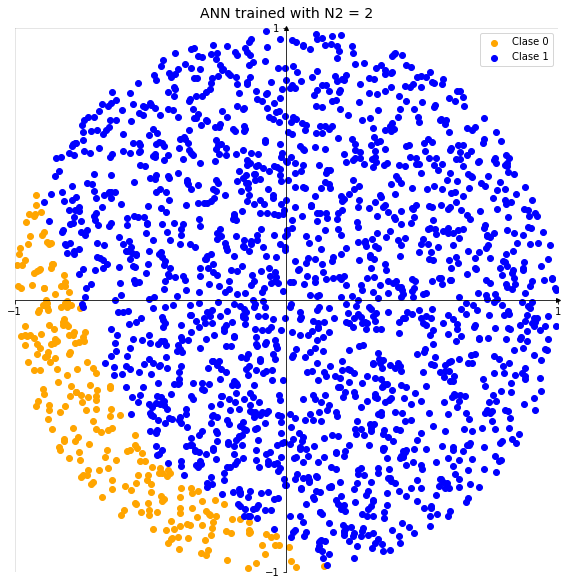

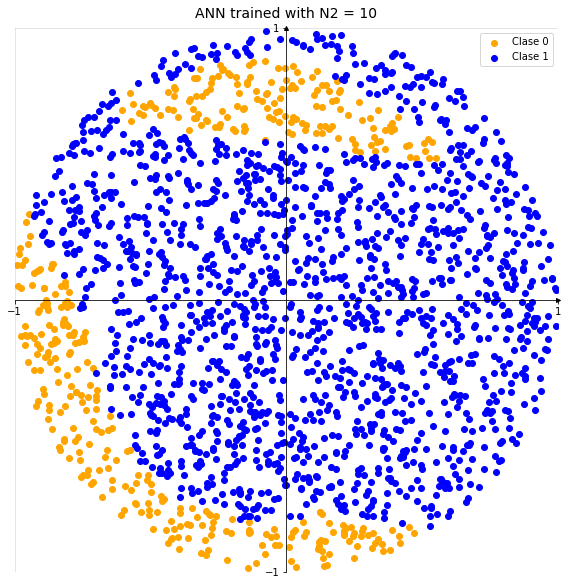

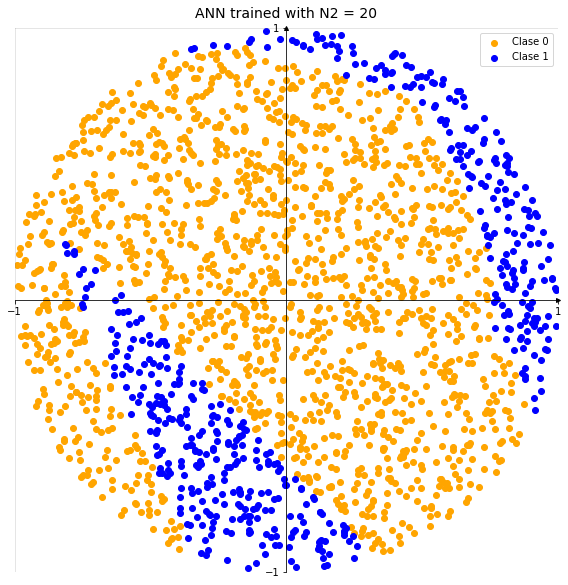

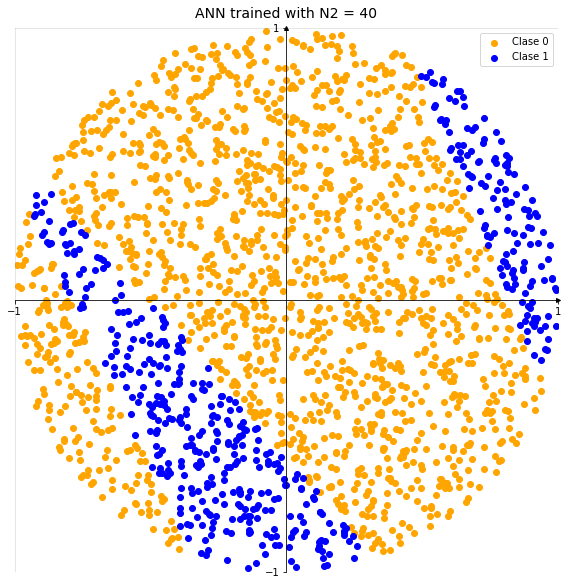

In [2]:
# Valores utilizados para crear la red neuronal
epochs=20 # numero de epocas que entrena cada vez
eta=0.1 # learning rate
alfa=0.9 # momentum
evals=1000 # evalauciones del entrenamiento

col_names = [0, 1, 'Class']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Creo el conjunto de datos utilizado para entrenar y vaidar
df_data_spirals = generate_spirals(600)
# Separo un 20% al azar para conjunto de validación
X_data, y_data = df_data_spirals[x_col_names], df_data_spirals[y_col_name]
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=0, test_size=0.2)

# Genero el conjunto de test
df_test_spirals = generate_spirals(2000)
X_test, y_test = df_test_spirals[x_col_names], df_test_spirals[y_col_name]

# Itero para cada cantidad de neuronas en la capa intermedia
for N2 in [2, 10, 20, 40]:
  # Creo la red neuronal
  classif = create_net_classifier(N2, eta, alfa, epochs)

  # La entreno con los conjuntos generados anteriormente
  best_net, e_train, e_val, e_test = train_net(classif, evals, X_train, y_train, X_val, y_val, X_test, y_test)
  
  # Predigo sobre el conjunto de test
  predict_test = best_net.predict(X_test)
  df_predict = df_test_spirals.copy(deep = True)
  df_predict['Class'] = predict_test

  # Grafico los resultados
  graph_df(df_predict, "ANN trained with N2 = {0}".format(N2))

### Conclusiones
En los gráficos obtenidos se puede ver que este modelo con los parámetros utilizados 
no sirve para este problema, obteniendo resultados no satisfactorios, inferiores
a los obtenidos con árboles de decisión.

--------------------------------------------------------------------------------
## Ejercicio 2

In [3]:
# Valores utilizados para crear la red neuronal
epochs=50 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=300 # evalauciones del entrenamiento
etas=[0.1, 0.01, 0.001] # learning rate
alfas=[0, 0.5, 0.9] # momentum

col_names = [0, 1, 'Class']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Leo el conjunto de datos utilizado para entrenar y vaidar
df_data_elipses = pd.read_csv("datasets/elipses/dos_elipses.data", header=None, names = col_names)
# Separo un 20% al azar para conjunto de validación
X, y = df_data_elipses[x_col_names], df_data_elipses[y_col_name]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.2)

# Leo el conjunto de test
df_test_elipses = pd.read_csv("datasets/elipses/dos_elipses.test", header=None, names = col_names)
X_test, y_test = df_test_elipses[x_col_names], df_test_elipses[y_col_name]

best_mean_test_error = math.inf
table = []

# Itero para cada combinación de learning rate y momentum
for (eta, alfa) in [(e, a) for e in etas for a in alfas]:
  train_errors = []
  val_errors = []
  test_errors = []

  # Para cada combinación realizo 10 entrenamientos iguales
  for i in range(10):
    # Creo la red neuronal
    classif = create_net_classifier(N2, eta, alfa, epochs)
  
    # La entreno con los conjuntos generados anteriormente
    best_net, e_train, e_val, e_test = train_net(classif, evals, X_train, y_train, X_val, y_val, X_test, y_test)

    # Junto todos los errores en listas 2d donde hay una fila por cada una de las
    # 10 redes y las columnas son los errores por etapa
    train_errors.append(e_train)
    val_errors.append(e_val)
    test_errors.append(e_test)

  # Conviertos las listas de errores a arrays para poder calcular con la
  # librería Numpy
  train_errors = np.asarray(train_errors)
  val_errors = np.asarray(val_errors)
  test_errors = np.asarray(test_errors)
  
  # Calculo los promedios de los errores por cada etapa (columna)
  mean_train_errors = train_errors.mean(axis = 0)
  mean_val_errors = val_errors.mean(axis = 0)
  mean_test_errors = test_errors.mean(axis = 0)

  # Busco el mínimo error de validación (y su índice) entre los promedios por cada etapa
  min_val_error = np.min(mean_val_errors)
  index_min_val_error = np.where(mean_val_errors == min_val_error)[0][0]

  # Para la etapa del mínimo error de validación busco su error de test
  mean_min_test_error = mean_test_errors[index_min_val_error]

  # Si es el mínimo error de test hasta ahora lo guardo junto a su eta, alfa
  # y datos de errores correspondientes
  if mean_min_test_error < best_mean_test_error:
    best_mean_test_error = mean_min_test_error
    best_eta = eta
    best_alfa = alfa
    # Guardo estos errores para graficarlos luego
    best_train_errors = np.copy(mean_train_errors)
    best_val_errors = np.copy(mean_val_errors)
    best_test_errors = np.copy(mean_test_errors)

  # Guardo la combinación eta, alfa con su error de test calculado antes
  table.append([eta, alfa, mean_min_test_error])

# Para los mejores errores obtenidos creo un dataframe para graficar los datos
# obtenidos
errors = []

for i in range(evals):
  errors.append([best_train_errors[i], i * epochs, "Train error"])
  errors.append([best_val_errors[i], i * epochs, "Validation error"])
  errors.append([best_test_errors[i], i * epochs, "Test error"])

ej3_errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
ej3_errors_df.to_csv("datasets/etas_alfas/ann_etas_alfas_errors.csv", index = False)

ej3_errors_table_df = pd.DataFrame(table, columns = ["Learning rate", "Momentum", "Mean test error"])
ej3_errors_table_df.to_csv("datasets/etas_alfas/ann_etas_alfas_table.csv", index = False)
print("Mejor eta: {0} mejor alfa: {1} with test de error promedio: {2}".format(best_eta, best_alfa, best_mean_test_error))
ej3_errors_table_df

Mejor eta: 0.01 mejor alfa: 0.9 with test de error promedio: 0.02679999999999998


,Learning rate,Momentum,Mean test error
0,0.100,0.0,0.04770
1,0.100,0.5,0.04555
2,0.100,0.9,0.09390
3,0.010,0.0,0.23290
4,0.010,0.5,0.11235
5,0.010,0.9,0.02680
6,0.001,0.0,0.24350
7,0.001,0.5,0.24350
8,0.001,0.9,0.22685


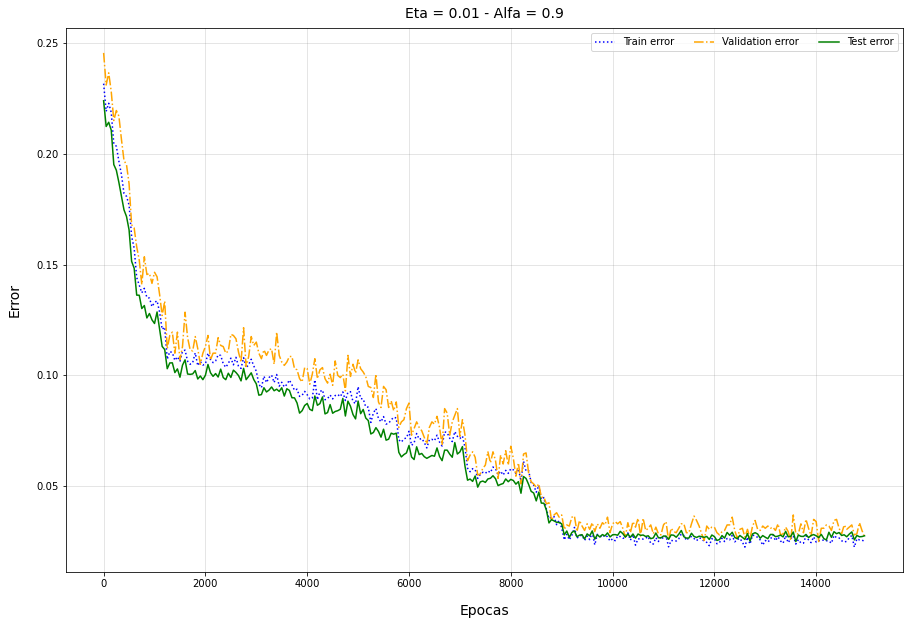

In [3]:
errors_df = pd.read_csv("datasets/etas_alfas/ann_etas_alfas_errors.csv")
graph_errors(errors_df, 'Epocas', title = "Eta = 0.01 - Alfa = 0.9")

### Conclusiones

Luego de entrenar redes utilizando las posibles combinaciones para los valores 
de eta y alfa dados, podemos ver que la mejor combinación es utilizar un 
eta igual a 0.01 y alfa igual a 0.9, obteniendo el menor test de error de entre
todos.

En el gráfico se observa que no se obtiene un sobreajuste ya que los errores
de entrenamiento y test se mantienen cercanos.

A mi parecer, estos valores resultan efectivos ya que al tener un momentum más alto
el modelo no se estanca fácilmente en un mínimo local y el learning rate es suficiente
para que el modelo aprenda con la cantidad de iteraciones dadas, pero no lo
suficientemente alto para obtener un sobreajuste.

--------------------------------------------------------------------------------
## Ejercicio 3

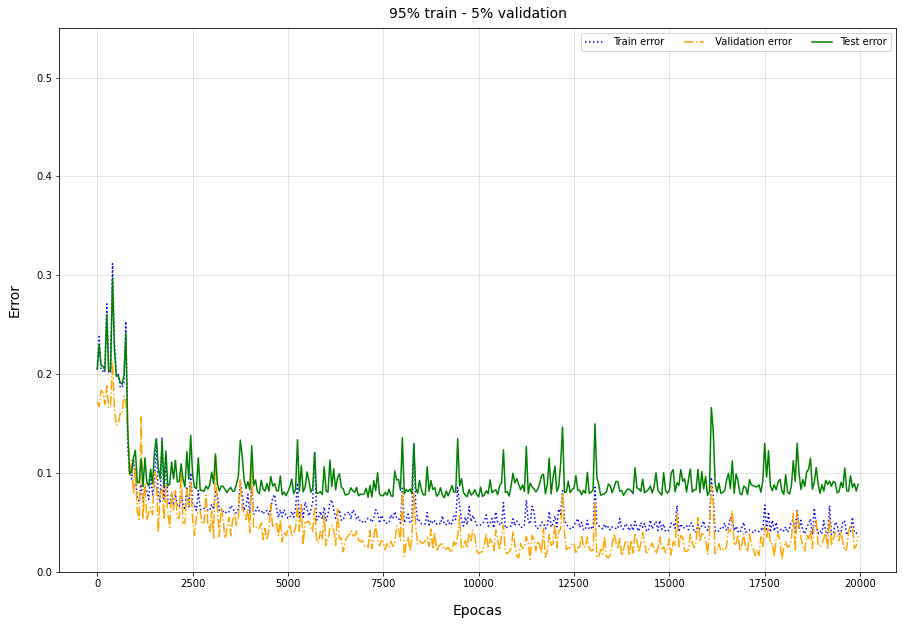

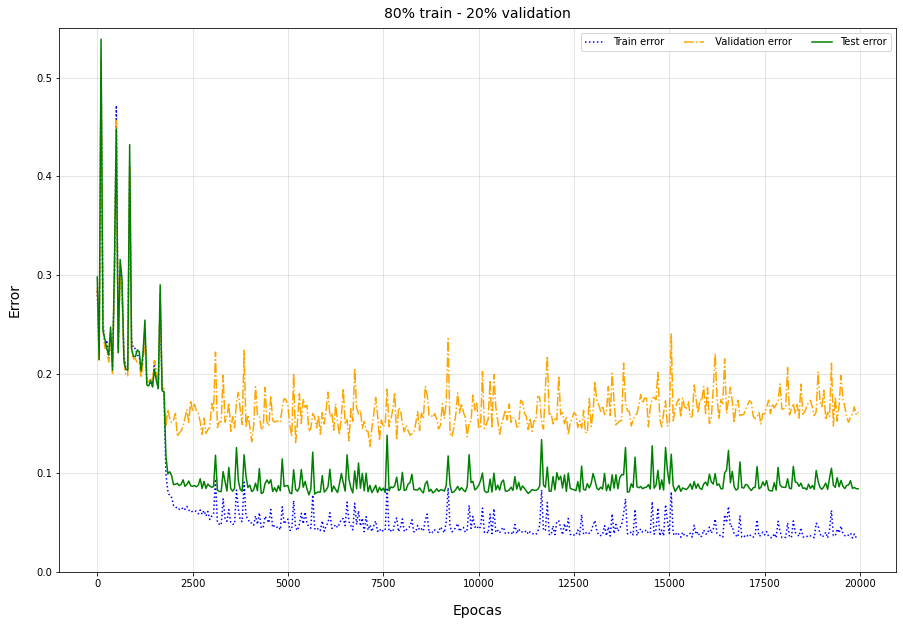

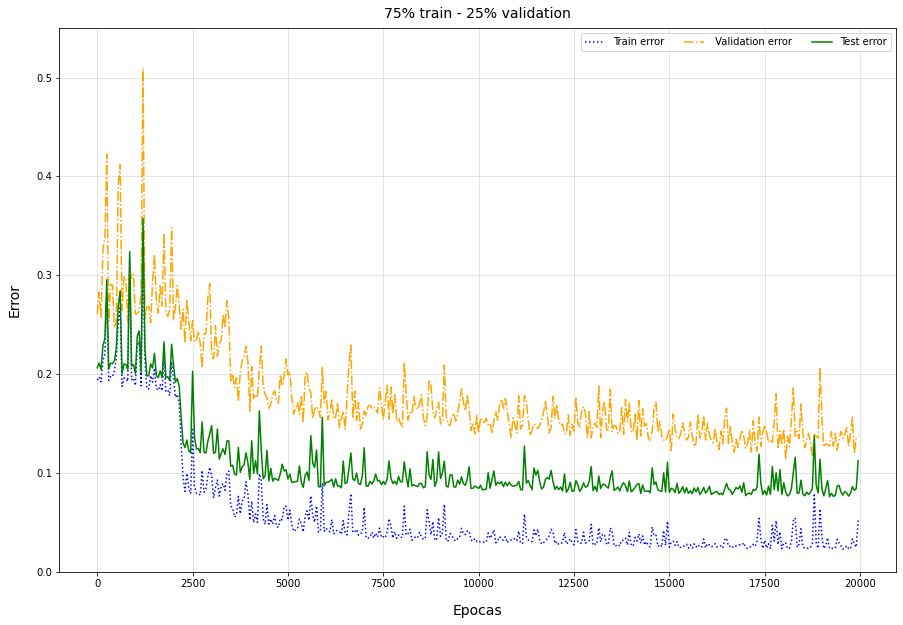

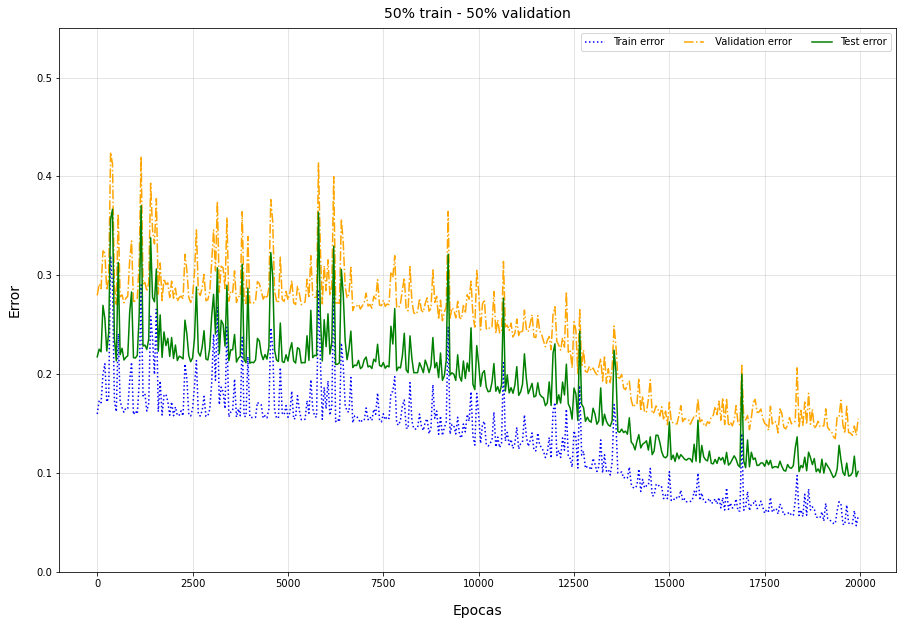

In [5]:
# Valores utilizados para crear la red neuronal
epochs=50 # numero de epocas que entrena cada vez
N2=30  # neuronas en la capa oculta
evals=400 # evalauciones del entrenamiento
eta=0.01 # learning rate
alfa=0.9 # momentum

col_names = list(range(5)) + ['Value']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Leo el conjunto de datos utilizado para entrenar y validar
df_data_ikeda = pd.read_csv("datasets/ikeda/ikeda.data", header=None, names = col_names, delim_whitespace=True, skipinitialspace=True)
# Leo el conjunto de test
df_test_ikeda = pd.read_csv("datasets/ikeda/ikeda.test", header=None, names = col_names, delim_whitespace=True, skipinitialspace=True)
X_test, y_test = df_test_ikeda[x_col_names], df_test_ikeda[y_col_name]

for val_size in [0.05, 0.2, 0.25, 0.5]:
  errors = []
  # Separo al azar para conjunto de validación
  X, y = df_data_ikeda[x_col_names], df_data_ikeda[y_col_name]
  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=val_size)

  # Creo la red neuronal
  regr = create_net_regressor(N2, eta, alfa, epochs)
  # La entreno con los conjuntos generados anteriormente
  best_net, e_train, e_val, e_test = train_net(regr, evals, X_train, y_train, X_val, y_val, X_test, y_test)
  
  for i in range(evals):
    errors.append([e_train[i], i * epochs, "Train error"])
    errors.append([e_val[i], i * epochs, " Validation error"])
    errors.append([e_test[i], i * epochs, "Test error"])

  errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
  graph_errors(errors_df, "Epocas", title = "{0}% train - {1}% validation".format(int((1 - val_size) * 100), int(val_size * 100)), y_lim=0.55)


### Conclusiones

En los gráficos se puede observar que al principio del entrenamiento, cuando el
error todavía es alto este disminuye de forma más abrupta a menor tamaño
del conjunto de validación, acercándose al mínimo error obtenido para cada red
con menos evaluaciones, probablemente debido a que se le dan más datos para su
entrenamiento.

Hacia el final del entrenamiento, los errores de test se mantienen similares entre todos
los gráficos, la mayores diferencias se pueden notar en las curvas de error
de entrenamiento y validación donde en todos los gráficos el error de validación
se mantiene mayor a los errores de entrenamiento y test excepto en el primero.
Esto me hace pensar que separar un 5% de los datos para validación puede ser
insuficiente para validar (valga la redundancia) correctamente nuestro modelo, por lo que pienso
que las proporciones de 80%-20% y 75%-25% pueden dar mejores resultados.

--------------------------------------------------------------------------------
## Ejercicio 4

In [6]:
# Valores utilizados para crear la red neuronal
epochs=20 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=4000 # evalauciones del entrenamiento
eta=0.05 # learning rate
alfa=0.3 # momentum


col_names=list(range(12)) + ['Value']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Leo el conjunto de datos utilizado para entrenar y vaidar
df_train_ssp = pd.read_csv("datasets/ssp/ssp.data", header=None, names = col_names)
# Leo el conjunto de test
df_test_ssp = pd.read_csv("datasets/ssp/ssp.test", header=None, names = col_names)

# Separo los conjuntos de entrenamiento y test en conjuntos
# de datos de entrada y con las respuestas.
X_train, y_train = df_train_ssp[x_col_names], df_train_ssp[y_col_name]
X_test, y_test = df_test_ssp[x_col_names], df_test_ssp[y_col_name]

gammas = [10 ** i for i in range(-6, 1)] # weight-decays

table = []
best_error_test = math.inf

for gamma in gammas:
  # Creo la red neuronal
  regr = create_net_regressor(N2, eta, alfa, epochs, gamma)

  # La entreno con los conjuntos generados anteriormente
  errors = []
  weights = []

  for i in range(evals):
    regr.fit(X_train, y_train)

    squared_sum_weights = sum(map(lambda a : np.sum(np.power(a, 2)), regr.coefs_))

    predict_train = regr.predict(X_train)
    predict_test = regr.predict(X_test)

    actual_error_train = sk.metrics.mean_squared_error(y_train, predict_train)
    actual_error_test = sk.metrics.mean_squared_error(y_test, predict_test)  

    errors.append([actual_error_train, i * epochs, "Train error"])
    errors.append([actual_error_test, i * epochs, "Test error"])
    weights.append([i * epochs, squared_sum_weights])

  table.append([gamma, actual_error_train, actual_error_test])
  
  if actual_error_test < best_error_test:
    best_error_test = actual_error_test
    best_gamma = gamma
    best_sum_weight = squared_sum_weights
    best_errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
    best_weights_df = pd.DataFrame(weights, columns = ["Epocas", "Pesos"])

ej4_errors_table_df = pd.DataFrame(table, columns = ["Gamma", "Train error", "Test error"])
ej4_errors_table_df.to_csv("datasets/gammas/ann_gammas_table.csv", index = False)
best_errors_df.to_csv("datasets/gammas/ann_gammas_errors.csv", index = False)
best_weights_df.to_csv("datasets/gammas/ann_gammas_weights.csv", index = False)
print("Mejor gamma: {0} con error de test: {1} y suma de pesos al cuadrado: {2}".format(best_gamma, best_error_test, best_sum_weight))
ej4_errors_table_df

Mejor gamma: 0.0001 con error de test: 0.005310874129426363 y suma de pesos al cuadrado: 17.04765243986654


,Gamma,Train error,Test error
0,0.000001,0.004338,0.006685
1,0.000010,0.003774,0.005656
2,0.000100,0.004912,0.005311
3,0.001000,0.008037,0.007577
4,0.010000,0.024579,0.021748
5,0.100000,0.043161,0.040230
6,1.000000,0.042461,0.038527


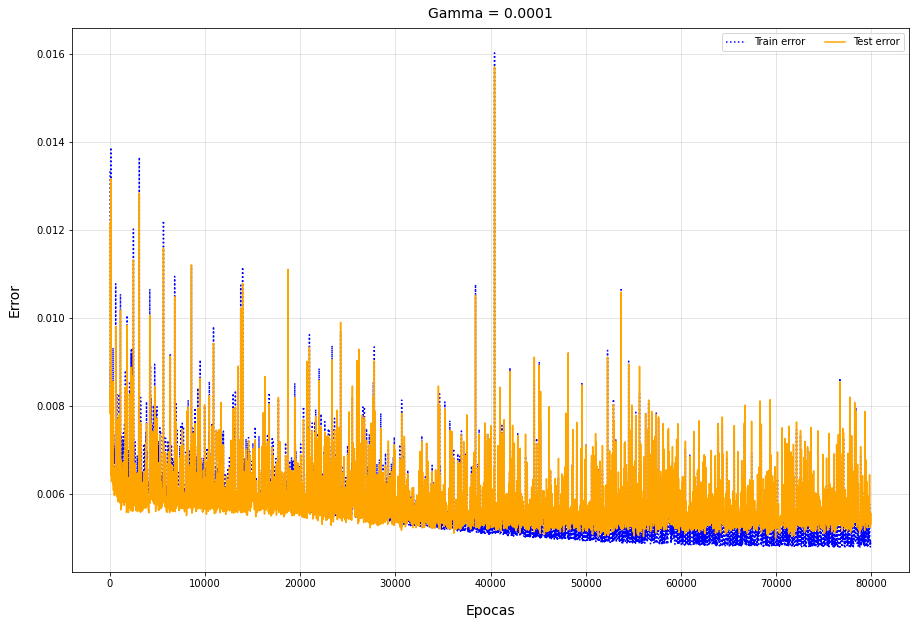

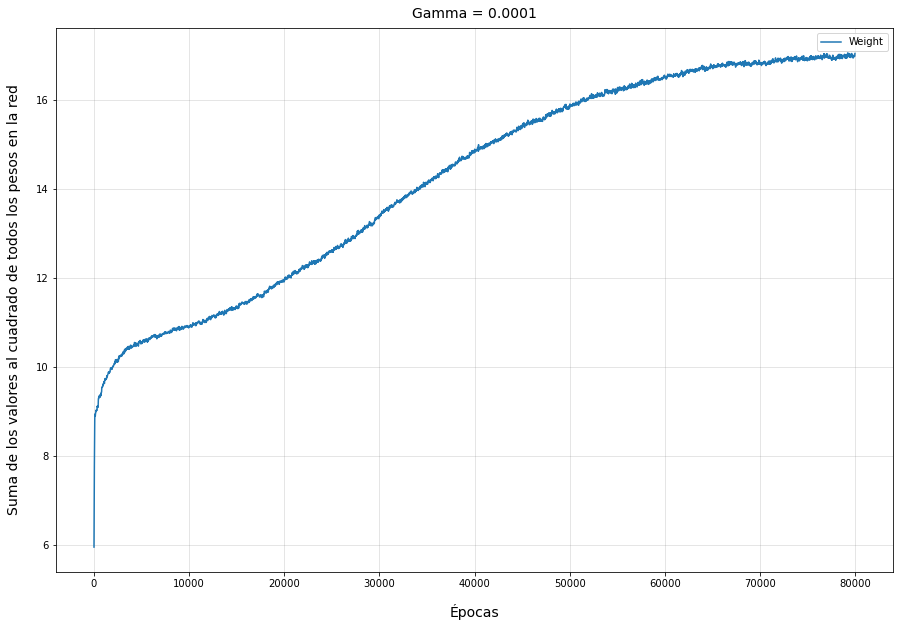

In [2]:
errors_df = pd.read_csv("datasets/gammas/ann_gammas_errors.csv")
weights_df = pd.read_csv("datasets/gammas/ann_gammas_weights.csv")

graph_errors(errors_df, 'Epocas', title = "Gamma = 0.0001")
graph_weights(weights_df, 'Epocas', title = "Gamma = 0.0001")

### Conclusiones
En este problema, el gamma con menor error de test fue 0.0001 o $10^{-5}$ con
un error de 0.00531 y 0.00491 de error de entrenamiento, por lo que puedo decir
que no hubo sobreajuste.

Otro valor de gamma bueno fue $10^{-4}$, donde se obtuvo un error de test
apenas mayor (0.00565) y un error de entrenamiento menor (0.00377), quizás 
podría decir que hubo más sobreajuste con este valor, pero al hablar de milésimas
de diferencia en el error no sabría decir si es significativo.

Para gamma igual a $10^{-5}$, al tener el menor error de test, elijo ese valor
para utilizar en los próximos ejercicios.

En ninguno de los gammas probados se encontró un sobreajuste notable.

--------------------------------------------------------------------------------
## Ejercicio 5

In [8]:
# Valores utilizados para crear la red neuronal
epochs=50 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=400 # evalauciones del entrenamiento
eta=0.01 # learning rate
alfa=0.9 # momentum
gamma=10 ** -5 # weight-decay

errors = []

for d in [2 ** i for i in range(1, 6)]:
  x_col_names = list(range(d))
  y_col_name = 'Class'

  # Genero los conjuntos de test para cada d
  df_test_diag = generate_diagonal(d, 10000, 0.78)
  df_test_para = generate_parallel(d, 10000, 0.78)

  X_test_diag, y_test_diag = df_test_diag[x_col_names], df_test_diag[y_col_name]
  X_test_para, y_test_para = df_test_para[x_col_names], df_test_para[y_col_name]

  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(d, 250, 0.78)
    df_train_para = generate_parallel(d, 250, 0.78)

    X_train_diag, y_train_diag = df_train_diag[x_col_names], df_train_diag[y_col_name]
    X_train_para, y_train_para = df_train_para[x_col_names], df_train_para[y_col_name]

    # Creo las redes neuronales
    classif_diag = create_net_classifier(N2, eta, alfa, epochs, gamma)
    classif_para = create_net_classifier(N2, eta, alfa, epochs, gamma)

    for i in range(evals):
      classif_diag.fit(X_train_diag, y_train_diag)
      classif_para.fit(X_train_para, y_train_para)

    predict_train_diag = classif_diag.predict(X_train_diag)
    predict_test_diag = classif_diag.predict(X_test_diag)
    predict_train_para = classif_para.predict(X_train_para)
    predict_test_para = classif_para.predict(X_test_para)

    actual_error_train_diag = sk.metrics.zero_one_loss(y_train_diag, predict_train_diag)
    actual_error_test_diag = sk.metrics.zero_one_loss(y_test_diag, predict_test_diag)  
    actual_error_train_para = sk.metrics.zero_one_loss(y_train_para, predict_train_para)
    actual_error_test_para = sk.metrics.zero_one_loss(y_test_para, predict_test_para)

    errors.append([actual_error_train_diag, d, "ANN - Train diagonal"])
    errors.append([actual_error_test_diag, d, "ANN - Test diagonal"])
    errors.append([actual_error_train_para, d, "ANN - Train parallel"])
    errors.append([actual_error_test_para, d, "ANN - Test parallel"])

ej5_errors_ann_df = pd.DataFrame(errors, columns = ["Error", "d", "Class"])
ej5_errors_ann_df.to_csv("datasets/dimensions/ann_dimensions_errors.csv", index = False)

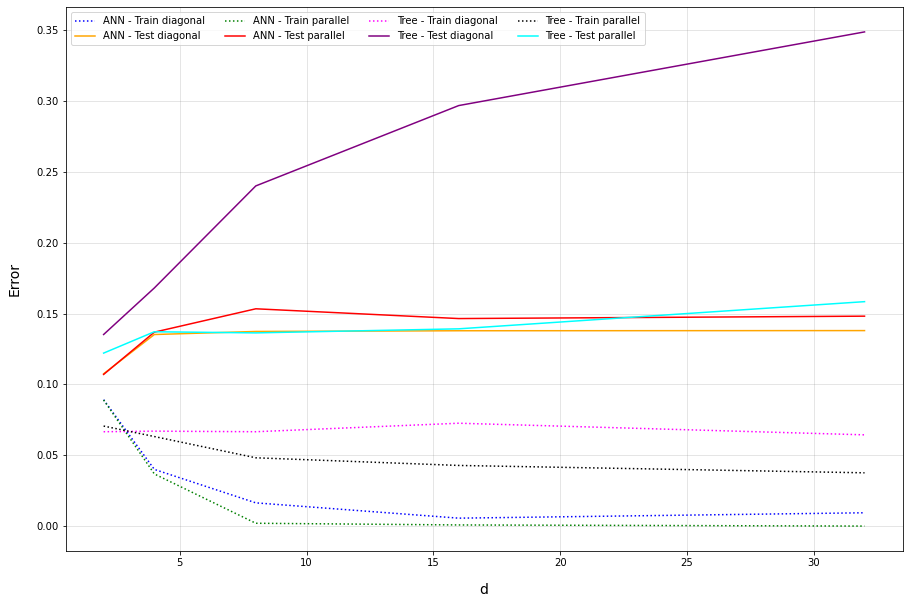

In [3]:
ej5_errors_ann_df = pd.read_csv("datasets/dimensions/ann_dimensions_errors.csv")
ej5_errors_tree_df = pd.read_csv("datasets/dimensions/tree_dimensions_errors.csv")
ej5_errors_df = pd.concat([ej5_errors_ann_df, ej5_errors_tree_df])
graph_errors(ej5_errors_df, "d")

### Conclusiones

Lo primero que pude observar, es que para las redes neuronales en estos problemas,
el error de entrenamiento se acerca mucho a 0, llegando hasta a ser exactamente 0
en las dimensiones mayores, lo que me resultó curioso.

Luego, en el problema "paralelo" el error con las redes neuronales al principio
es menor al error de los árboles de decisión, luego lo supera pero a mayor
dimensionalidad el error se mantiene estable y para dimensiones grandes resulta
ser menor.

Para el problema "diagonal" el error se mantiene similar al error del problema "paralelo".

Por lo que puedo concluir que las redes neuronales son más aptas para estos
problemas de mayor dimensionalidad y no-lineales como el problema "diagonal".

--------------------------------------------------------------------------------
## Ejercicio 6.1

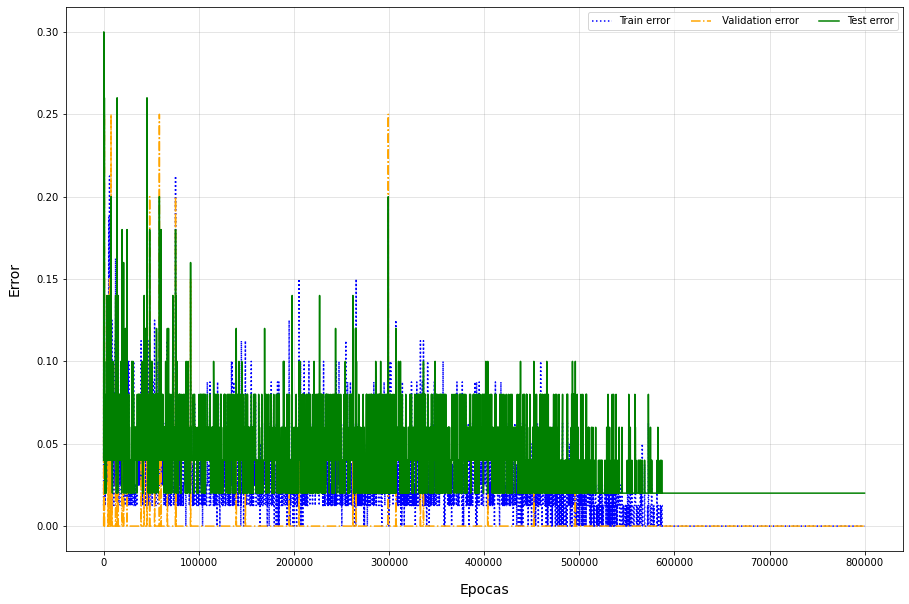

In [7]:
from sklearn.datasets import load_iris

epochs=200 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=4000 # evalauciones del entrenamiento
eta=0.01 # learning rate
alfa=0.9 # momentum

iris = load_iris()
X = iris.data
y = iris.target
X_data, X_test, y_data, y_test = train_test_split(X, y, random_state=0, test_size = 1/3)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=0, test_size = 0.2)

# Creo la red neuronal
classif = create_net_classifier(N2, eta, alfa, epochs)

# La entreno con los conjuntos generados anteriormente
best_net, e_train, e_val, e_test = train_net(classif, evals, X_train, y_train, X_val, y_val, X_test, y_test)

errors = []

for i in range(evals):
    errors.append([e_train[i], i * epochs, "Train error"])
    errors.append([e_val[i], i * epochs, " Validation error"])
    errors.append([e_test[i], i * epochs, "Test error"])

errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
graph_errors(errors_df, "Epocas")

### Conclusiones
Utilizando parámetros obtenidos en ejercicios anteriores y con una cantidad alta
de evaluaciones logro entrenar un clasificador con un error muy pequeño,
de aproximadamente 0.025 o 2.5% en test y nulo en validación y entrenamiento,
obteniendo un modelo muy bueno para este problema.

Otro detalle a notar es como al principio del entrenamiento, durante las primeras
etapas del entrenamiento (hasta aproximadamente 58000 evaluaciones)
el error varía drásticamente y presenta picos altos, pero luego el error
presenta una curva totalmente plana sin variaciones. A partir de esto puedo suponer
que realizar más evaluaciones es innecesario ya que los pesos de la red no 
cambiarán más.



--------------------------------------------------------------------------------
## Ejercicio 6.2

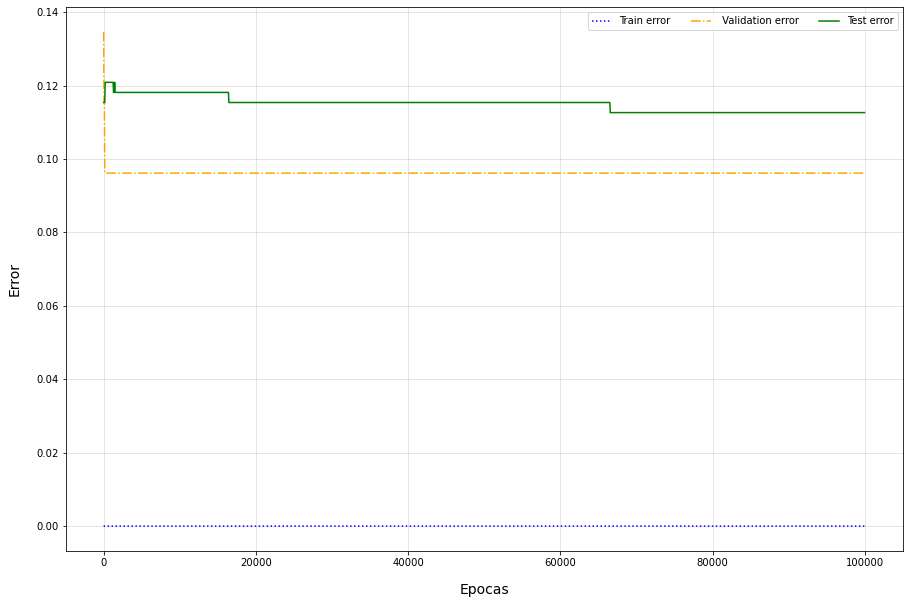

In [4]:
epochs=50 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=2000 # evalauciones del entrenamiento
eta=0.01 # learning rate
alfa=0.9 # momentum

col_names = list(range(960)) + ['Class']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Leo el conjunto de datos utilizado para entrenar y validar
df_data_faces = pd.read_csv("datasets/faces/faces.data", header=None, names = col_names)
# Leo el conjunto de test
df_test_faces = pd.read_csv("datasets/faces/faces.test", header=None, names = col_names)

max_value = max(df_data_faces.max().max(), df_test_faces.max().max())

X_data, y_data = df_data_faces[x_col_names], df_data_faces[y_col_name]
X_test, y_test = df_test_faces[x_col_names], df_test_faces[y_col_name]

X_data, X_test = X_data / max_value , X_test / max_value

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=0, test_size=0.2)

# Creo la red neuronal
classif = create_net_classifier(N2, eta, alfa, epochs)

# La entreno con los conjuntos generados anteriormente
best_net, e_train, e_val, e_test = train_net(classif, evals, X_train, y_train, X_val, y_val, X_test, y_test)

errors = []

for i in range(evals):
    errors.append([e_train[i], i * epochs, "Train error"])
    errors.append([e_val[i], i * epochs, " Validation error"Q])
    errors.append([e_test[i], i * epochs, "Test error"])

errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
graph_errors(errors_df, "Epocas")

### Conclusiones
En este problema a diferencia del anterior el error se mantiene más estable sin
muchas variaciones. El error de entrenamiento es nulo desde la primera evaluación hasta
la última y el de validación comienza más alto pero luego de las primeras iteraciones
se mantiene igual hasta el final.

El error de test es bajo desde un principio y se mantiene estable, bajando
unas pocas centésimas cada miles de evaluaciones, por lo que puedo suponer que al
entrenar redes neuronales para este problema, estas logran ajustar rápidamente los pesos
para aprender el problema y luego sólo se van modificando de a pequeñas cantidades,
bajando el error de test de forma marginal.

--------------------------------------------------------------------------------
## Ejercicio 7

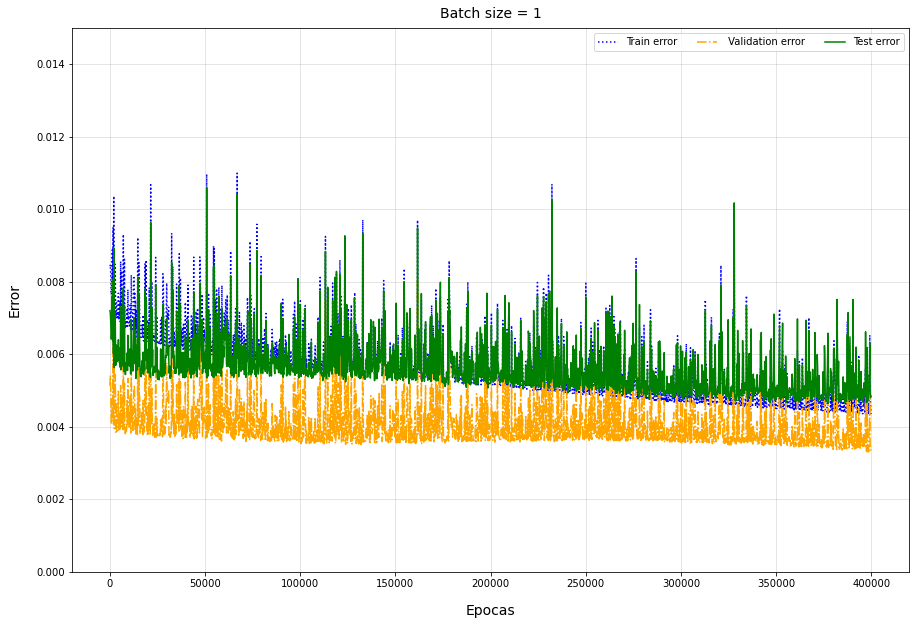

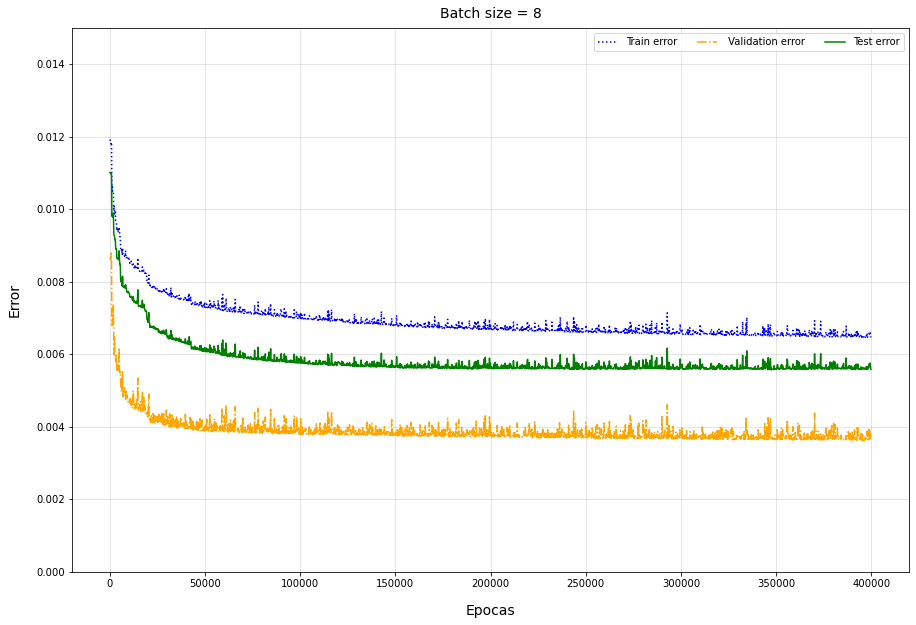

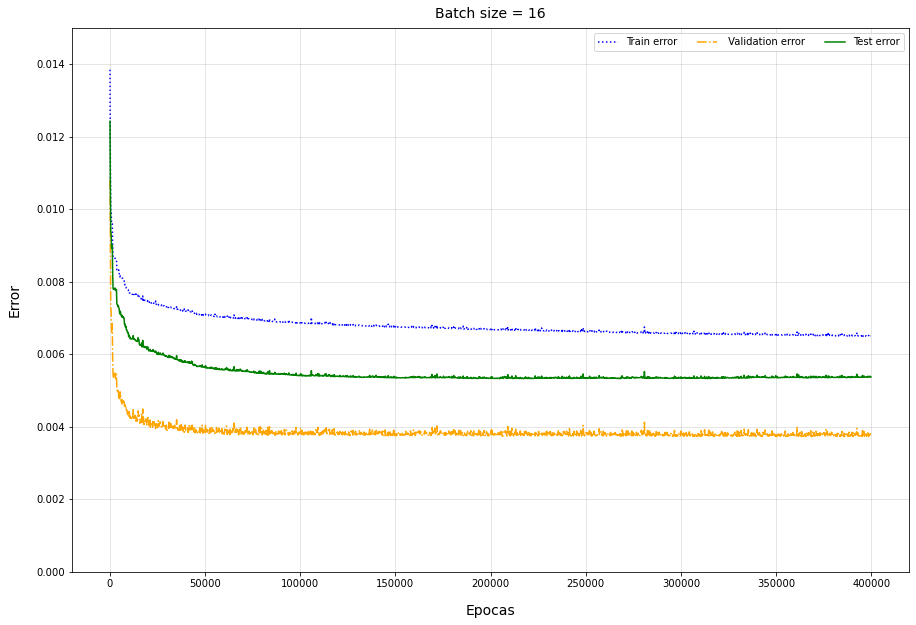

In [2]:
# Valores utilizados para crear la red neuronal
epochs=200 # numero de epocas que entrena cada vez
N2=6  # neuronas en la capa oculta
evals=2000 # evalauciones del entrenamiento
eta=0.05 # learning rate
alfa=0.3 # momentum

batches = [1, 8, 16]

col_names=list(range(12)) + ['Value']
x_col_names = col_names[:-1]
y_col_name = col_names[-1]

# Leo el conjunto de datos utilizado para entrenar y vaidar
df_data_ssp = pd.read_csv("datasets/ssp/ssp.data", header=None, names = col_names)
# Leo el conjunto de test
df_test_ssp = pd.read_csv("datasets/ssp/ssp.test", header=None, names = col_names)

# Separo los conjuntos de entrenamiento, validación y test en conjuntos
# de datos de entrada y con las respuestas.
X, y = df_data_ssp[x_col_names], df_data_ssp[y_col_name]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.2)
X_test, y_test = df_test_ssp[x_col_names], df_test_ssp[y_col_name]


best_error_test = math.inf

for batch in batches:
  errors = []
  # Creo la red neuronal
  regr = create_net_regressor(N2, eta, alfa, epochs, batch = batch)
  best_net, e_train, e_val, e_test = train_net(regr, evals, X_train, y_train, X_val, y_val, X_test, y_test)
  
  for i in range(evals):
    errors.append([e_train[i], i * epochs, "Train error"])
    errors.append([e_val[i], i * epochs, " Validation error"])
    errors.append([e_test[i], i * epochs, "Test error"])
  
  errors_df = pd.DataFrame(errors, columns = ["Error", "Epocas", "Class"])
  graph_errors(errors_df, "Epocas", title = "Batch size = {0}".format(batch), y_lim = 0.015)

### Conclusiones
En los gráficos se puede observar como a mayor batch size también es mayor el error inicial,
pero este error a su vez varía mucho menos mientras se sigue entrenando la red,
obteniendo resultados finales similares en los 3 gráficos mostrados, donde solo
para un batch size igual a 1 el error es apenas menor.

Otro detalle a notar es que ejecutando el código en mi computadora para un batch size
igual a 1 tardó 1m10s en completar el entrenamiento, mientras que para
batch size 8 y 16 ambos se completaron en 10s aproximadamente.

--------------------------------------------------------------------------------
## Extra
### Tiempos de ejecución por ejercicio:

- Ejercicio 1: 6m 43s
- Ejercicio 2: 134m 22.9s
- Ejercicio 3: 42.9s
- Ejercicio 4: 13m 59.5s
- Ejercicio 5: 276m 39.9s
- Ejercicio 6.1: 1m16s
- Ejercicio 6.2: 70m aproximadamente
- Ejercicio 7: 1m24s 